# Experiments 1

This notebook conducts experiments of the paper. Run 'Create_grid_MTS' Before running this notebook, since the experiments are based on the MTS created over the grids of the satellite image time series. Note that some experiments can take a long time. These experiments have been carried out with the geographic based embedding, $f^g$, but they can be repeated with the clustering-based embedding $f^c$ by creating the grid of MTS with the corresponding model.

Given a collection of multivariate time series this notebook compute the following results:
- Calculate the distance matrix between MTSs
- Plot the region of interest according to colors given by PCA to each MTS
- Run K-means clustering over the collection of MTSs
- Plot the region of interest according to the clustering
- Visualize cluster representatives (sequences of tiles closest to each centroid)
- Calculate and visualize interpolation between centroids
- Compute and plot the minimum spanning tree among cluster centroids
- Compute and plot the 2D projection of the MTS with tSNE and MDS methods

## Load libraries and functions

In [47]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append('../')

from src.aux_functions import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks

from sklearn.manifold import TSNE, MDS
import seaborn as sns
import pandas as pd  

from sklearn.metrics import silhouette_score, calinski_harabasz_score
from PIL import Image

## Load time series data

Load the MTS associated to a region. This experiment must be conducted after running `Creat_grid_MTS.ipynb`

In [31]:
# Set parameters
n_elems = 3
z_dim = 512
h = 110
n_samples = h*h
n_clus = 5
# Directory where the sequences of tiles have been saved
tile_dir = '../data/NE-TXN/tiles' # by default

In [14]:
# Directory with the MTS
area = 'NE-TXN'
data_dir = os.path.join('../data', area, 'MTS')

In [15]:
X = np.load(data_dir + '/X_epoch50_512_100_100K_NE-TXN.npy')

Load the matrix of distances between time series.
Some of the experiments such as the projections are based on the distance matrix between TS.

In [52]:
Dist_mat = np.load('distances_NE-TXN.npy')

## Color of tiles with PCA
We assign a color to each MTS by using PCA and plot the region.

In order to assign meaningful colors we extract the three main comopenents of the vectors composed by the concatenation of time series. Then, the three mian components are scaled between 0 and 255 in order to represent rgb colors.

In [17]:
# Concatenate TS to assign colors
concat_ts = np.zeros((n_samples, n_elems*z_dim))
for i in range(n_samples):
    concat_ts[i] = np.concatenate(X[i,:n_elems])

In [18]:
# PCA with 3 compnents concatenated TS
pca_ts = PCA(n_components=3)
pca_ts.fit(concat_ts)
# Explaiend variance
np.sum(pca_ts.explained_variance_ratio_)

0.5939957335369078

Once the PCA model is built we transform each vector (concatenated TS) to three components and then these components are translated to colors, numbers between 0 and 255.

(-0.5, 109.5, 109.5, -0.5)

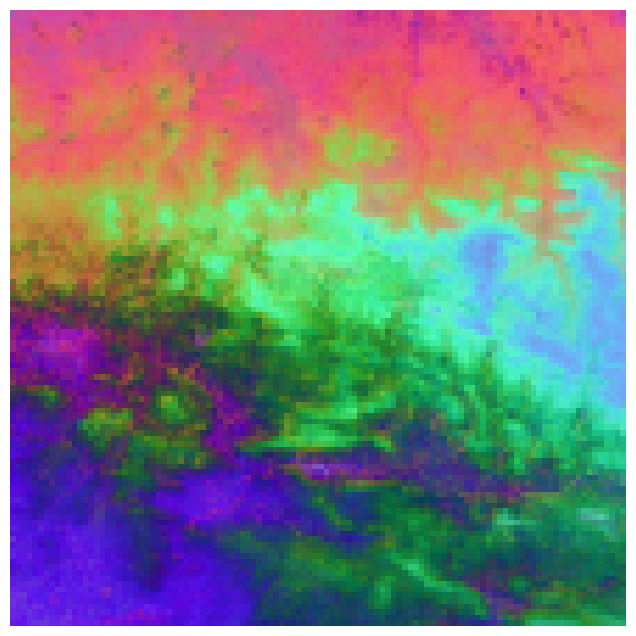

In [19]:
# Assing components to all
x_pca = pca_ts.transform(concat_ts)

# Cerate colors
x_colors = pca2colors(x_pca, n_samples)

# Transform to image
image_pca = x_colors.reshape(110,110,3)
image_pca = image_pca.astype(np.uint8)

# Plot
plt.figure(figsize=(8,8))
plt.imshow(image_pca)
plt.axis("off")
#plt.savefig(os.path.join(res_dir_fig, 'pca_colors_f1.png'), bbox_inches='tight')

The result is an image whose pixels are the tiles of the original image. The color of each pixel represents the associated time series. In this way, similar colors represent closer time series i.e. the similar semantic behaviours over time. 

## k-means and PCA

K-means clustering of the multivariate time series with $K=5$. 

In [21]:
# Run clustering
ts_clustering = TimeSeriesKMeans(n_clusters=n_clus, metric="euclidean", n_init=5, max_iter_barycenter=5).fit(X)
ts_clusters = ts_clustering.labels_
ts_centroids = ts_clustering.cluster_centers_
counts = np.unique(ts_clusters, return_counts=True)

In [22]:
# Save clusters of ecah MTS
np.save('clusters_k5_NE-TXN.npy', ts_clusters)
# Save centroids
np.save('centroids_k5_NE-TXN.npy', ts_centroids)

#### Quality measures

In [54]:
# Silhouette score
print(silhouette_score(Dist_mat, ts_clusters, metric="precomputed"))
# K-means error
ts_clustering.inertia_

0.2783108749917703


2107.222038889008

Create pairs of 2D coordinates for evaluating the clustering over the geography

In [55]:
# Create pairs of coordinates for 2D evaluation
Pairs = np.zeros((n_samples, 2))
DistGrid = np.zeros((n_samples, n_samples))
cont = 0
for i in range(h):
    for j in range(h):
        Pairs[cont] = [i,j]
        cont = cont + 1

In [56]:
print(silhouette_score(Pairs, ts_clusters, metric="euclidean"))
print(calinski_harabasz_score(Pairs, ts_clusters))

0.1337669374629132
3989.3523842947493


#### Plot the satellite image after the clustering

In [35]:
# Concatenate centroids to plot with PCA
ts_centroids_vec = np.zeros((n_clus, n_elems*z_dim))
for i in range(n_clus):
    ts_centroids_vec[i] = np.concatenate(ts_centroids[i])

In [36]:
# Concatenate MTS
concat_ts = np.zeros((n_samples, n_elems*z_dim))
for i in range(n_samples):
    concat_ts[i] = np.concatenate(X[i,:n_elems])

In [37]:
# Fit PCA with the collection of concatenated MTS
pca_ts = PCA(n_components=3)
pca_ts.fit(concat_ts)

PCA(n_components=3)

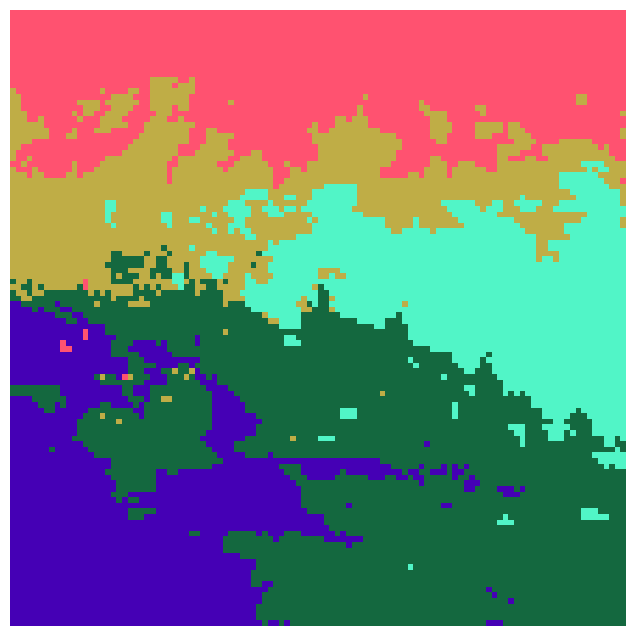

In [51]:
plot_clustering_map(n_clus, ts_clusters, ts_centroids_vec, pca_ts, save=False, res_dir_fig='', name='')

## Cluster representatives, interpolations and semantic graph

Visualize the sequences of tiles closest to each centroid

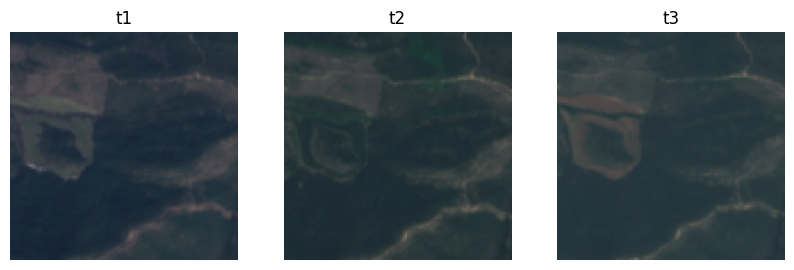

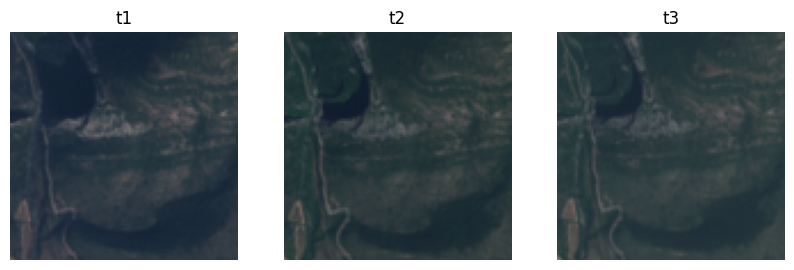

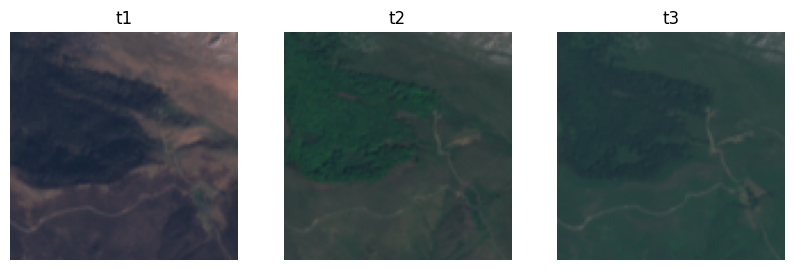

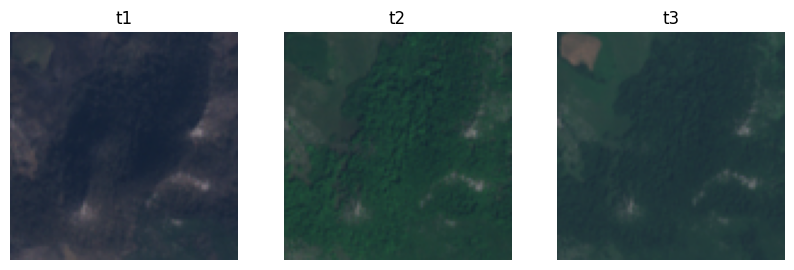

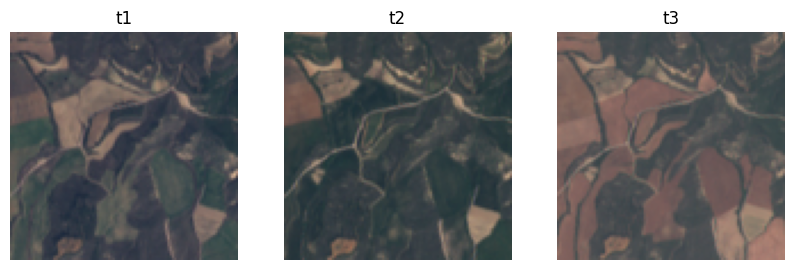

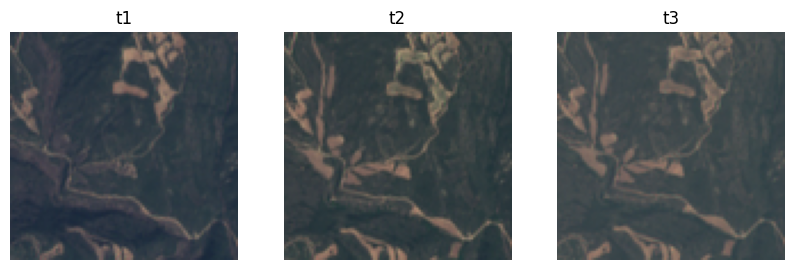

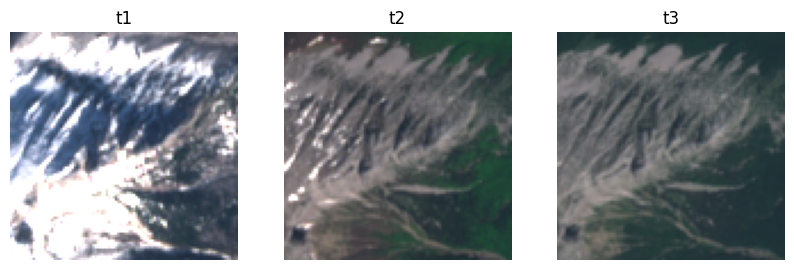

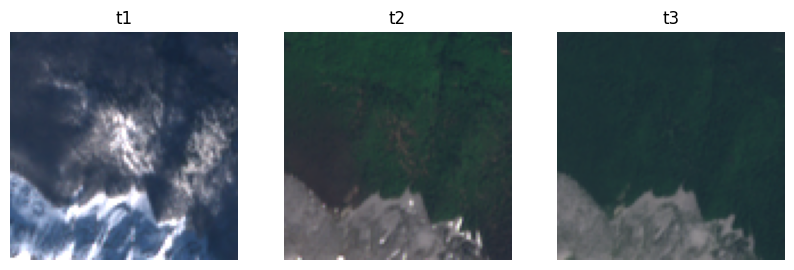

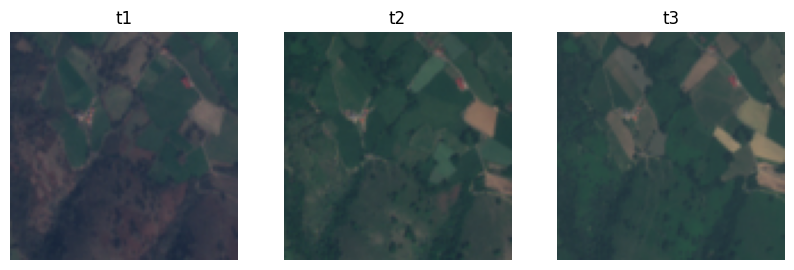

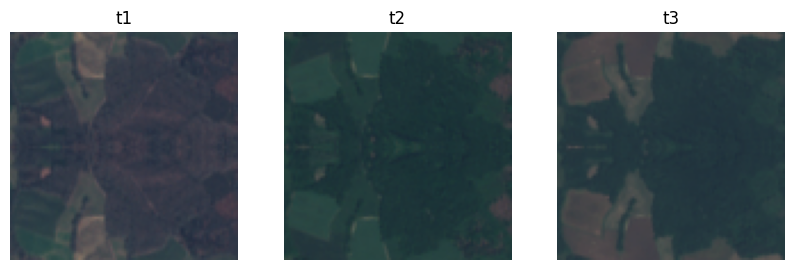

In [117]:
for c in range(n_clus):
    C = ts_centroids[c]
    Dts = np.zeros(n_samples)
    for i in range(n_samples):
        Dts[i] = eucl_dist_ts(C, X[i])
    Dc_sort = np.argsort(Dts)
    # Plot the r closest 
    r = 2
    for i in Dc_sort[:r]:
        Plot_TS_long(i, 3, tile_dir)

Calculate interpolation with $w=0.25, 0.5, 0.75$ between clusters. As an example, we plot the interpolation for $w=0.5$ between clusters number 1 and 3. The semantic graph computed later can be used to explore interpolation.

In [146]:
# Calculate the TS between two adjacent clusters c1 and c2
from scipy.interpolate import interp1d
inter = np.zeros((n_elems, 512))
c1 = 1
c2 = 3
for i in range(n_elems):
    fst = ts_centroids[c1][i]
    snd = ts_centroids[c2][i]
    linfit = interp1d([1,5], np.vstack([fst, snd]), kind='linear', axis=0)
    inter[i] = linfit(3)

In [144]:
# Example of using the function interp1d
linfit = interp1d([1,5], np.vstack([[1,1], [2,2]]), kind='linear', axis=0)
linfit(3)

array([1.5, 1.5])

In [160]:
# The closest sequence of tiles to the interpolation
Dts = np.zeros(n_samples)
for i in range(n_samples):
    Dts[i] = eucl_dist_ts(inter, X[i])
Dc_sort_inter = np.argsort(Dts)

# Realculate the closest sequence of tiles to each cluster
Dts = np.zeros(n_samples)
for i in range(n_samples):
    Dts[i] = eucl_dist_ts(ts_centroids[c1], X[i])
Dc_sort_C1 = np.argsort(Dts)

Dts = np.zeros(n_samples)
for i in range(n_samples):
    Dts[i] = eucl_dist_ts(ts_centroids[c2], X[i])
Dc_sort_C2 = np.argsort(Dts)

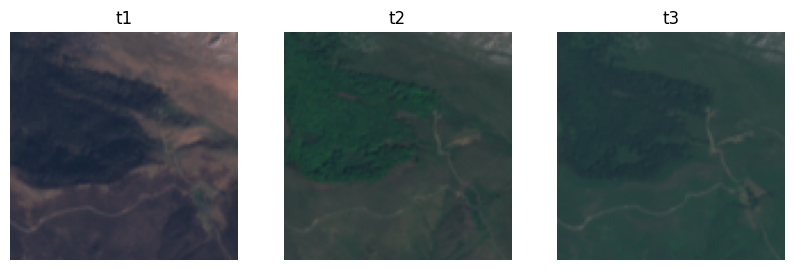

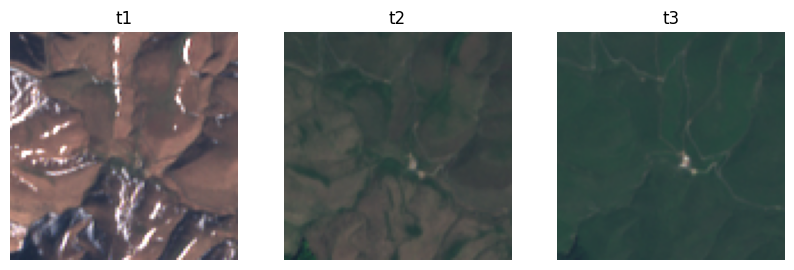

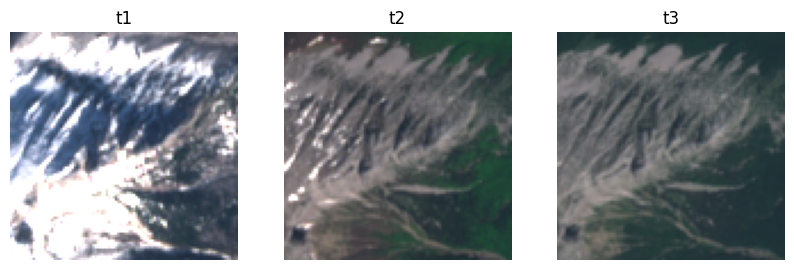

In [161]:
# Plot the cluster representatives and the interpolation between them
Plot_TS_long(Dc_sort_C1[0], 3, tile_dir)
Plot_TS_long(Dc_sort_inter[0], 3, tile_dir)
Plot_TS_long(Dc_sort_C2[0], 3, tile_dir)

## Semantic graph

Minimum spanning tree among cluster centroids

In [126]:
Dist_centroids = dist_mat_ts(ts_centroids, n_clus)

In [127]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx

In [128]:
Tcsr = minimum_spanning_tree(Dist_centroids)
# Tree as matrix
Tcsr.toarray().astype(int)

array([[  0, 126, 112,   0,   0],
       [  0,   0,   0, 122,  96],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

In [129]:
colors = []
for i in range(n_clus):
    colors.append(matplotlib.colors.to_hex(V_trans[i]/255))

In [130]:
MST = Tcsr.toarray().astype(int)

In [131]:
G = nx.from_numpy_array(np.array(MST))
widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

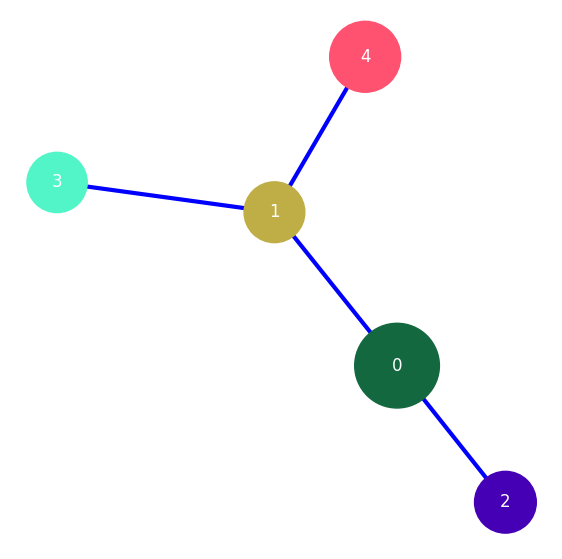

In [145]:
plt.figure(figsize=(7,7))
w=list(widths.values())/np.sum(list(widths.values()))*20
pos = nx.spring_layout(G, scale=0.2)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=counts[1],
                       node_color=colors,
                       alpha=1)
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=3,
                       edge_color='blue')
nx.draw_networkx_labels(G, pos=pos,
                        font_color='white')
plt.box(False)
plt.show()

## 2D projections of the MTS and the clustering

2D projections of the MTS based on the distance matrix

In [99]:
# tSNE 2d projection
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=2).fit_transform(Dist_mat)

Assign a different color for each 2D point according to previous PCA colors. The colors could be assigned in different ways depending on the purpose. For the MDS projection, we use the colors calculated previously for the clusters.

In [108]:
colors_pca = []
for i in range(n_samples):
    colors_pca.append(matplotlib.colors.to_hex(x_colors[i]/255))
number = [i for i in range(n_samples)]

Plot tSNE projection with PCA colors

<Axes: xlabel='comp-1', ylabel='comp-2'>

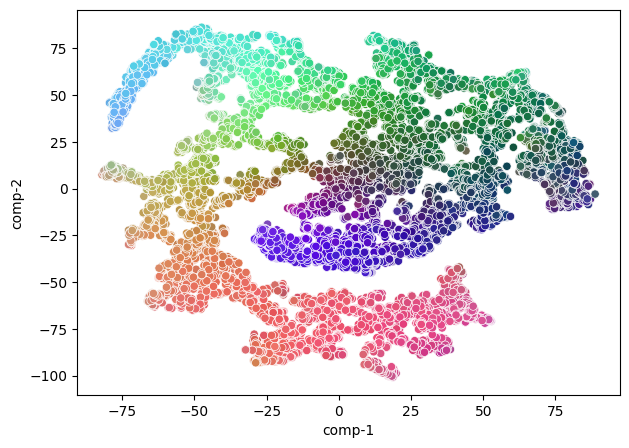

In [112]:
plt.rcParams['figure.figsize'] = (7,5)
df = pd.DataFrame()
df["y"] = number
df["comp-1"] = tsne[:,0]
df["comp-2"] = tsne[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue="y",
                palette=colors_pca[:],
                data=df, legend = False)

In [105]:
# MDS projection
mds = MDS(n_components=2, dissimilarity='precomputed').fit_transform(Dist_mat)

<Axes: xlabel='comp-1', ylabel='comp-2'>

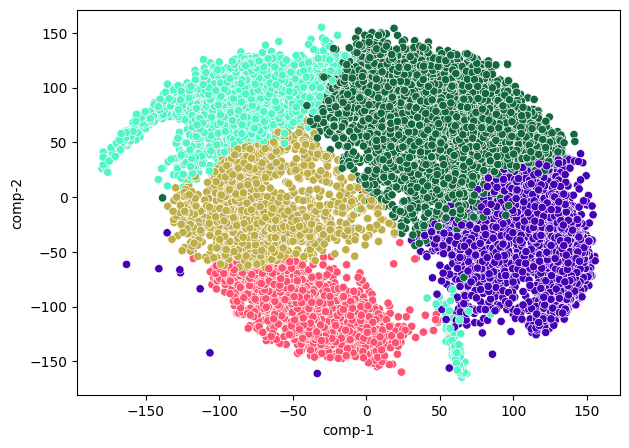

In [113]:
# Use colores given to each cluster by PCA
df = pd.DataFrame()
df["y"] = ts_clusters
df["comp-1"] = mds[:,0]
df["comp-2"] = mds[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=colors,
                data=df, legend = False)